# 计算机视觉深度学习入门
* 理解卷积神经网络 `convolutional neural network`
* 使用数据增强来降低过拟合
* 使用预训练的卷积神经网络进行特征提取
* 微调预训练的卷积神经网络

## 8.1 卷积神经网络入门

### [C] 8.1 实例化一个小型卷积神经网络

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# 卷积神经网络接收的输入张量形状为(image_height, image_width, image_channels)
inputs  = keras.Input(shape=(28, 28, 1))
x       = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x       = layers.MaxPooling2D(pool_size=2)(x)
x       = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x       = layers.MaxPooling2D(pool_size=2)(x)
x       = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x       = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

### [C] 8.2 概要信息

In [ ]:
model.summary()

### [C] 8.3 在MNIST图像上训练卷积神经网络

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images  = test_images.reshape((10000, 28, 28, 1))
test_images  = test_images.astype('float32') / 255

model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(train_images, train_labels, epochs=5, batch_size=64)

### [C] 8.4 评估卷积神经网络

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test evalute:{test_loss:.2f}:{test_acc:.3f}')

### 8.1.1 卷积运算
* 卷积神经网络学到的模式具有**平移不变性**`translation invariant`
* 卷积神经网络学到模式的**空间层次结构**`spatial hierarchies of patterns`

#### 特征图(`feature map`)的3阶张量，2个空间轴(高度和宽度)和1个深度轴(通道轴)
* ##### 对于RGB图像，深度轴的维度大小为3(红、绿、蓝)。
* ##### 对于黑白图像，深度为1(表示灰度值)

#### 卷积由以下两个参数定义：
* ##### 从输入中提取的图块尺寸
* ##### 输出特征图的深度

#### 卷积工作原理
* 在3维输入特征图上滑动(slide)这些3X3或5X5的窗口。
* 在每个可能得位置停下来并提取周围特征得3维图块，形状为(`window_height`, `window_width`, `input_depth`)
* 然后将每个这样得3维图块与学到的权重矩阵(**卷积核**`convolution kernal`)做张量积，使其转换为形状为`(output_depth,)`的1维向量。
* 每个图块得到一个向量，然后对所有这些向量进行空间重组，将其转换为形状为(`height`, `width`, `output_depth`)的3维输出特征图。
* 输出特征图中的每个空间位置都对应输入特征图中的相同位置。
* e.g. 利用3X3的窗口，向量**output[i, j, :]**来自于3维图块**input[i-1:i+1, j-1:j+1, :]**


#### 1 理解边界效应和填充

#### 2 理解卷积步幅 `stride`

### 8.1.2 最大汇聚(`max-pooling`)运算

#### [C] 8.5 一个没有最大汇聚层、结构错误的卷积神经网络
* 这种结构不利于学习特征的空间层级结构
* 最后一个特征图对每个样本都有61,952个元素。太多了！

In [ ]:
inputs  = keras.Input(shape=(28, 28, 1))
x       = layers.Conv2D(filters=32,  kernel_size=3, activation='relu')(inputs)
x       = layers.Conv2D(filters=64,  kernel_size=3, activation='relu')(x)
x       = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x       = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_no_max_pool.summary()

## 8.2 在小型数据集上从头开始训练一个卷积神经网络

### 8.2.1 深度学习对数据量很小的问题的适用性

### 8.2.2 下载数据

In [ ]:
'''
from google.colab import files

files.upload()
'''


#### [C] 8.6 将图像复制到训练目录、验证目录和测试目录

In [99]:
import os, shutil, pathlib

# 原始数据集的解压目录
original_dir = pathlib.Path('original')
# 保存较小数据集的目录
new_base_dir = pathlib.Path('cat_vs_dogs_small')

def make_subset(subset_name, start_index, end_index):
    for category in ('Cat', 'Dog'):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)

        fnames = [f'{i}.jpg' for i in range(start_index, end_index + 1)]
        for fname in fnames:
            dst_fname = f'{category}.{fname}'
            shutil.copyfile(src=original_dir / category / fname, dst=dir / dst_fname)

# 训练子集
make_subset('train'     , start_index=0,    end_index=999)
# 验证子集
make_subset('validation', start_index=1000, end_index=1499)
# 测试子集
make_subset('test'      , start_index=1500, end_index=2499)

### 8.2.3 构建模型

#### [C] 8.7 为猫狗分类问题实例化一个小型卷积神经网络

In [100]:
from tensorflow import keras
from tensorflow.keras import layers

# 输入尺寸为 180 * 180 的RGB图像
inputs = keras.Input(shape=(180, 180, 3))

# 将输入除以255，使其缩放至[0, 1]
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)

x = layers.Flatten()(x)

outputs = layers.Dense(1, activation='sigmoid')(x)
model   = keras.Model(inputs=inputs, outputs=outputs)

In [101]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                      

#### [C] 8.8 配置模型，以进行训练

In [102]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### 8.2.4 数据预处理
* 读取JPEG文件
* 将JPEG文件解码为RGB像素网格
* 将这些像素网格转换为浮点数张量
* 将这些张量调节为相同大小
* 将数据打包成批量(一个批量包含32张图像)

#### [C] 8.9 使用`image_dataset_from_directory()`读取图像

In [103]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset      = image_dataset_from_directory(new_base_dir / 'train'     , image_size=(180, 180), batch_size=32)
validation_dataset = image_dataset_from_directory(new_base_dir / 'validation', image_size=(180, 180), batch_size=32)
test_dataset       = image_dataset_from_directory(new_base_dir / 'test'      , image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [104]:
import numpy as np
import tensorflow as tf

random_numbers = np.random.normal(size=(1000, 16))
dataset        = tf.data.Dataset.from_tensor_slices(random_numbers)

In [105]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [106]:
batched_dataset = dataset.batch(32)

for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [107]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))

for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


#### [C] 8.10 显示Dataset生成的数据和标签的形状

In [108]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:'  , data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [109]:
print(os.path.abspath(new_base_dir))
print(os.path.abspath('convnet_from_scratch.keras'))

d:\01.Hello World\02.Programming\TensorFlow\08Chapter\cat_vs_dogs_small
d:\01.Hello World\02.Programming\TensorFlow\08Chapter\convnet_from_scratch.keras


#### [C] 8.11 利用Dataset拟合模型

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='convnet_from_scratch.keras',
        save_best_only=True,
        monitor='val_loss')]

history = model.fit(train_dataset, epochs=3, validation_data=validation_dataset, callbacks=callbacks)


##### **Notice**

Error information:
---
InvalidArgumentError: Graph execution error:

Input is empty.
[[{{node decode_image/DecodeImage}}]]
[[IteratorGetNext]] [Op:__inference_train_function_8740]

#### [C] 8.12 绘制训练过程中的精度曲线和损失曲线

In [ ]:
import matplotlib.pyplot as plt

accuracy     = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss         = history.history["loss"]
val_loss     = history.history["val_loss"]
epochs       = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy    , "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b" , label="Validation accuracy")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss    , "bo", label="Training loss")
plt.plot(epochs, val_loss, "b" , label="Validation loss")

plt.title("Training and validation loss")
plt.legend()

plt.show()

#### [C] 8.13 在测试集上评估模型

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

### 8.2.5 使用数据增强

#### [C] 8.14 定义一个数据增强代码块，以便将其添加到图像模型中

In [113]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),  # 将水平翻转应用于随机抽取的50%的图像
        layers.RandomRotation(0.1),       # 将输入图像在[-10%, +10%]的范围随机旋转，角度表示为[-36°, +36°]
        layers.RandomZoom(0.2),           # 放大或缩小图像，缩放比例在[-20%, +20%]范围内随机取值
    ]
)


#### [C] 8.15 随机显示几张增强后的训练图像

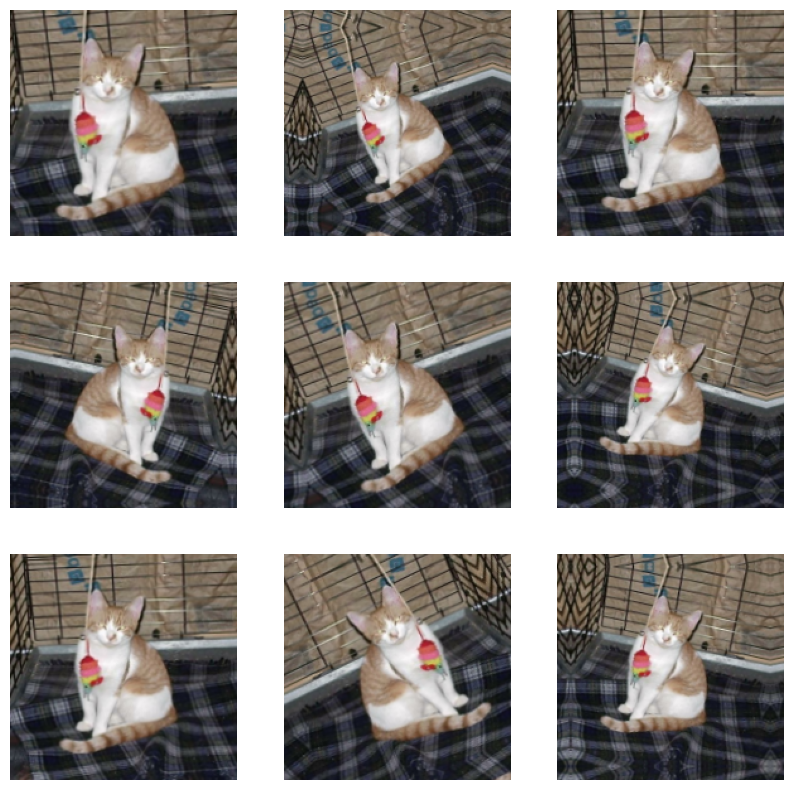

In [114]:
plt.figure(figsize=(10, 10))

# take(N)可以从数据集中仅抽取N个批量
for images, _ in train_dataset.take(1):
    for i in range(9):
        # 将数据增强代码块应用于图像批量
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        # 显示输出批量中的第一张图像。在9次迭代中，这都是对同一张图像的不同增强
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#### [C] 8.16 定义一个包含数据增强和`dropout`的新卷积神经网络

In [123]:
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

#model.compile(optimizer='rmsprop', 
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy']
#              )

#### [C] 8.17 训练一个正则化的卷积神经网络

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=1,
    validation_data=validation_dataset #,
    #callbacks=callbacks
    )

#### [C] 8.18 在测试集上评估模型

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)

print(f"Test accuracy: {test_acc:.3f}")

## 8.3 使用预训练模型
---
* 特征提取
* 微调模型

### 8.3.1 使用预训练模型做特征提取

#### [C] 8.19 将VGG16卷积基实例化

In [125]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',       # 指定模型初始化的权重检查点
    include_top=False,        # 指定是否包含密集连接分类器
    input_shape=(180, 180, 3) # 输入模型的图像张量的形状
)

58889256/58889256 [==============================] - 4s 0us/step


In [126]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### 1 不使用数据增强的快速特征提取

##### [C] 8.20 提取VGG16的特征和对应的标签

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels     =  get_features_and_labels(validation_dataset)
test_features, test_labels   =  get_features_and_labels(test_dataset)

##### [C] 8.21 定义并训练密集连接分类器

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

##### [C] 8.22 绘制结果

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history["accuracy"]
val_acc  = history.history["val_accuracy"]
loss     = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc    , "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b" , label="Validation accuracy")

plt.title("Training and validation accuracy")

plt.legend()

plt.figure()

plt.plot(epochs, loss    , "bo", label="Training loss")
plt.plot(epochs, val_loss, "b" , label="Validation loss")
 
plt.title("Training and validation loss")

plt.legend()

plt.show()

#### 2 使用数据增强的特征提取

##### [C] 8.23 将VGG16卷积基实例化并冻结

In [128]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
    
conv_base.trainable = False

In [129]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [130]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


##### [C] 8.25 在卷积基上添加数据增强代码块和分类器

In [131]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

##### [C] 8.26 在测试集上评估模型

In [ ]:
test_model = keras.models.load_model("feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)

print(f"Test accuracy: {test_acc:.3f}")

### 8.3.2 微调预训练模型

#### [C] 8.27 冻结除最后4层外的所有层

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

#### [C] 8.28 微调模型

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test accuracy: {test_acc:.3f}")